In [1]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import sys, itertools
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score

# 指定支持中文的字体，例如SimHei或者Microsoft YaHei
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

In [2]:
# 读取Excel文件
df = pd.read_excel('A1.xlsx', usecols=['销量（箱）', '金额（元）'])
# 去掉无数值的行
df.dropna(inplace=True)
# 将数据转换为NumPy数组
data_array = df.values
index = pd.date_range(start='2011-01', periods=data_array.shape[0], freq='M')
df = pd.DataFrame(data_array, index=index, columns=['销量', '金额'])

In [3]:
series = df.loc['2014-02':, '销量']
data = series.values

# 创建 MinMaxScaler 的实例
scaler = MinMaxScaler()
# 使用 fit_transform 方法来拟合数据并转换它
normalized_data = scaler.fit_transform(data.reshape(-1, 1)).reshape(-1)

normalized_series = pd.Series(normalized_data, index=series.index)

In [4]:
# 将Series转换为DataFrame，并设置日期为索引  
sales_df = normalized_series.reset_index()  
sales_df.columns = ['date', 'sales']  
sales_df['date'] = pd.to_datetime(sales_df['date'])
# 确保数据按日期排序  
sales_df = sales_df.sort_values('date')

In [5]:
# 创建特征集和目标集  
feature_length = 12
# 使用前 feature_length 个月的销量作为特征，预测下一个月的销量  
features = []  
targets = []  

sales_df['year'] = sales_df['date'].dt.year  
sales_df['month'] = sales_df['date'].dt.month  
  
for i in range(feature_length, len(sales_df)):  
	# 获取销量特征  
	sales_features = sales_df['sales'].iloc[i-feature_length:i].tolist()  

	# 获取年份和月份特征  
	year_feature = sales_df['year'].iloc[i]
	month_feature = sales_df['month'].iloc[i]

	year_feature = (year_feature - 2014) / 5
	month_feature = (month_feature - 1) / 6.

	# 将年份和月份添加到特征向量中  
	feature_vector = sales_features + [year_feature, month_feature]

	# 添加到特征集中  
	features.append(feature_vector)

	# 添加目标销量  
	targets.append(sales_df['sales'].iloc[i]) 
  
# 将特征和目标转换为numpy数组  
features = np.array(features)  
targets = np.array(targets)  

In [6]:
# 划分训练集和测试集  
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2)

In [7]:
# 创建XGBoost模型  
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.02, gamma=0, subsample=0.75,  
                         colsample_bytree=1, max_depth=7)
  
# 训练模型  
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.02, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

MSE: 376.07


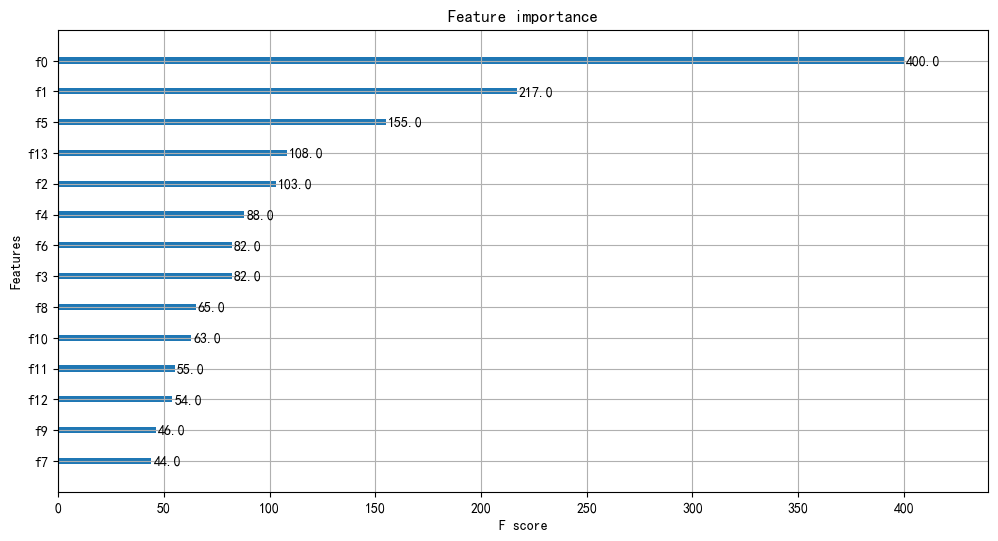

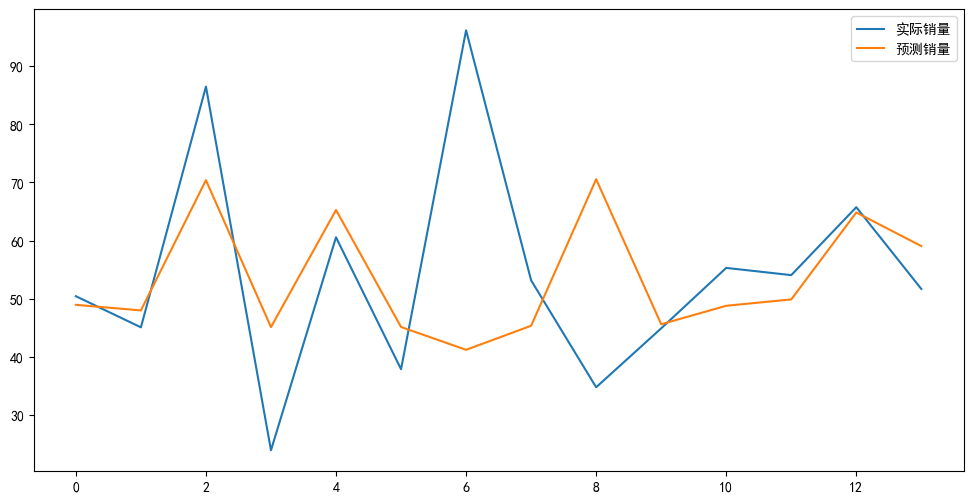

In [8]:
# 预测和评估  
y_pred = model.predict(X_test)  
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1)).reshape(-1)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(-1)
mse = mean_squared_error(y_pred_inv, y_test_inv)  
print("MSE: %.2f" % mse)

# 绘制特征重要性
plt.figure(figsize=(12, 6))
xgb.plot_importance(model, ax=plt.gca())
plt.show()

# 绘制预测结果
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='实际销量')
plt.plot(y_pred_inv, label='预测销量')
plt.legend()
plt.show()